## Домашняя работа #5.

**Kaggle: [competition](https://www.kaggle.com/competitions/hse-hw-5), [invite link](https://www.kaggle.com/t/e962ce15e33c4ff38e6569704a54a126)**

**Google опрос для отправки**: https://forms.gle/e1Ls9vFtiqhisFYi8 

**Kaggle deadline: 06/08/2022 12:59 PM UTC**

**Hard deadline: 09.06.2022 03:00:00 +0003 GMT**


### Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/Colab_Notebooks/CV/homework5')
dataset_root = "data"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output


import os
import pickle
from typing import Any, Callable, Optional, Tuple
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Compose
from torchvision.datasets.vision import VisionDataset
import torchvision.transforms as transforms

In [53]:
from utils import CIFAR10, DeviceDataLoader, get_default_device, to_device

### Загрузка датасета

Выбирать модель я буду на сплите train - val, а обучать для отправки на kaggle я буду на полном датасете, я создам несколько даталоадеров. Но для начала добавим аугментацию:


In [54]:
train_transform = transforms.Compose([
                                                 
    transforms.RandomCrop(size=32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])   
])

Разбиваем случайным образом датасет на обучение и валидацию. <br>
На первой части будем обучать модель классификации. <br>
На второй части будем оценивать качество во время экспериментов. <br>

In [55]:
data = CIFAR10(
    root=dataset_root,
    train=True)

train_data, val_data = torch.utils.data.random_split(
    data, 
    [40000, 10000], 
    generator=torch.Generator().manual_seed(42),
)


train_data.dataset.transform = train_transform
val_data.dataset.transform = test_transform

Инициализируем data loader-ы.

In [56]:
batch_size = 512
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, num_workers=2, pin_memory=True)

Передадим dataloader на device

In [57]:
device = get_default_device()
train_dataloader = DeviceDataLoader(train_dataloader, device)
val_dataloader = DeviceDataLoader(val_dataloader, device)

Посмотрим, какой размерности батчи выдает data loader.

In [58]:
X, y = next(iter(train_dataloader))
print("Shape of X [N, C, H, W]: ", X.shape)
print("Shape of y: ", y.shape, y.dtype)

Shape of X [N, C, H, W]:  torch.Size([512, 3, 32, 32])
Shape of y:  torch.Size([512]) torch.int64


### Функции для обучения и тестирования 

In [34]:
def show_progress(t):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t:3.3f}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('loss')
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3)
    ax1.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    ax2.set_title('accuracy')
    ax2.set_xlabel('time (epochs)')
    ax2.plot(val_ts, val_acc, c='green', marker='o', lw=5)
    plt.show() 


def train(epoch, dataloader, model, loss_fn, optimizer, sched=None, grad_clip=0.1, show=True):
    model.train()
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        optimizer.step()
        if sched is not None:
            sched.step()
        # Progress output
        if batch % interval == 0:
            t = epoch + (batch + 1)/num_batches
            train_ts.append(t)
            train_loss.append(loss.item())
            if show:
                show_progress(t)



def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def test(epoch, dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dl.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    val_ts.append(epoch+1)
    val_loss.append(test_loss)
    val_acc.append(correct)
    lr.append(get_lr(optimizer))
    show_progress(epoch+1)


### Модель классификации

Задаем архитектуру модели классификации. <br>
Тут большой простор для разных экспериментов. Из этого большого простора, я оставила две основных архитектуры, с которыми я эксперементировала при подборе параметров. В качестве финальной модели, я остановилась на ResNet9 с параметрами, которые приведены ниже. Было проведено множество эксперементов с разными размерами батча, lerning rate, scheduler и т д, но они остались за пределами этой тетрадки. <br>

In [61]:
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.flatten import Flatten
from torch.nn.modules.batchnorm import BatchNorm2d

import torch.nn as nn
import torch.nn.functional as F

def conv3x3(in_channels, out_channels, pool=True, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels)
    ]

    if pool:
        layers.append(nn.MaxPool2d((2, 2)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


class Backbone(nn.Module):
  def __init__(self, thickness=32, in_channels=3):
    super().__init__()
    self.block1 = conv3x3(in_channels, thickness, pool=False)
    self.block2 = conv3x3(thickness, thickness)
    self.block3 = conv3x3(thickness, thickness * 2, pool=False)
    self.block4 = conv3x3(thickness * 2, thickness * 2)
    self.block5 = conv3x3(thickness * 2, thickness * 4, pool=False)
    self.block6 = conv3x3(thickness * 4, thickness * 4)

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.block6(x)
    return x


class Head(nn.Module):
  def __init__(self, input_size, dropout=0.2, num_classes=10):
    super().__init__()
    self.dropout1 = nn.Dropout(dropout)
    self.linear1 = nn.Linear(input_size, input_size // 2)
    self.relu1 = nn.PReLU()
    self.dropout2 = nn.Dropout(dropout)
    self.linear2 = nn.Linear(input_size // 2, num_classes)

  def forward(self, x):
    x = self.dropout1(x)
    x = self.linear1(x)
    x = self.relu1(x)
    x = self.dropout2(x)
    x = self.linear2(x)
    return x


class Net(nn.Module):
    def __init__(self, thickness=32, in_channels=3, dropout=0.2, num_classes=10):
        super().__init__()


        self.backbone = Backbone(thickness=thickness, in_channels=in_channels)
        self.flatten = nn.Flatten()
        self.head = Head(
            input_size = thickness * 4 * 4 * 4, 
            dropout=dropout, 
            num_classes=num_classes
            )

    def forward(self, x):
        x = self.backbone(x)
        x = self.flatten(x)
        x = self.head(x)
        return x



In [35]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

### Обучение

Код для визуализации процесса обучения.

Каждые `interval` шагов оптимизации и в конце эпох мы записываем значения функции потерь и метрик в лог. <br>
Затем вызовом функции `show_progress` обновляем график обучения. <br>

Первая модель

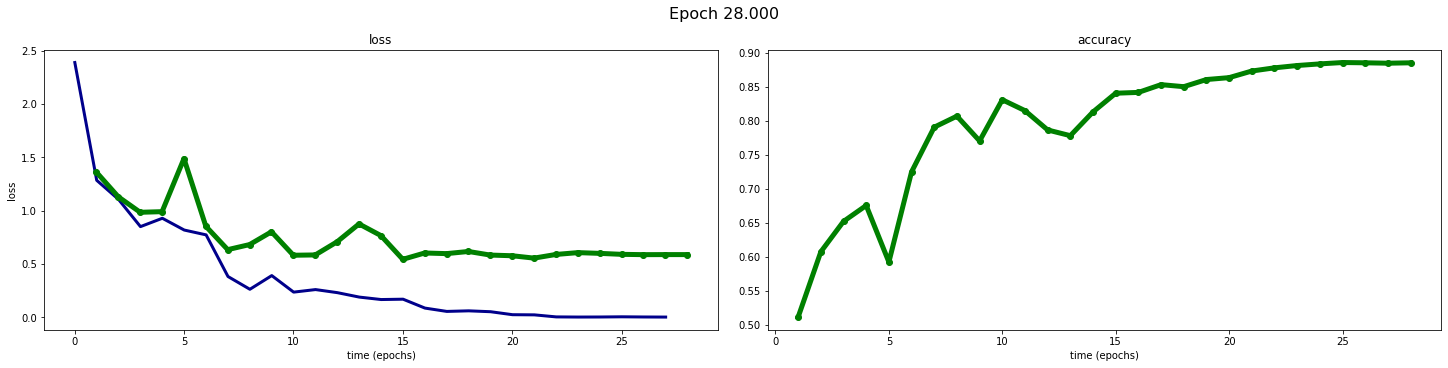

Epoch 1 LR 0.0007 Train Loss 2.3879 Val Loss 1.3595 Accuracy 0.5117
Epoch 2 LR 0.0017 Train Loss 1.2835 Val Loss 1.1286 Accuracy 0.6076
Epoch 3 LR 0.0031 Train Loss 1.1036 Val Loss 0.9834 Accuracy 0.6523
Epoch 4 LR 0.0049 Train Loss 0.8491 Val Loss 0.9894 Accuracy 0.6757
Epoch 5 LR 0.0066 Train Loss 0.9274 Val Loss 1.4868 Accuracy 0.5926
Epoch 6 LR 0.0082 Train Loss 0.8170 Val Loss 0.8524 Accuracy 0.7251
Epoch 7 LR 0.0094 Train Loss 0.7717 Val Loss 0.6331 Accuracy 0.7908
Epoch 8 LR 0.0099 Train Loss 0.3811 Val Loss 0.6808 Accuracy 0.807
Epoch 9 LR 0.0100 Train Loss 0.2615 Val Loss 0.8006 Accuracy 0.7706
Epoch 10 LR 0.0098 Train Loss 0.3899 Val Loss 0.5806 Accuracy 0.8311
Epoch 11 LR 0.0096 Train Loss 0.2348 Val Loss 0.5835 Accuracy 0.8151
Epoch 12 LR 0.0092 Train Loss 0.2587 Val Loss 0.7071 Accuracy 0.7867
Epoch 13 LR 0.0087 Train Loss 0.2298 Val Loss 0.8743 Accuracy 0.7783
Epoch 14 LR 0.0081 Train Loss 0.1882 Val Loss 0.7651 Accuracy 0.8132
Epoch 15 LR 0.0074 Train Loss 0.1653 Val Los

In [62]:
model = to_device(Net(thickness=64, dropout=0.2), device)

interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc, lr = [], [], [], []


epochs = 28
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader)) 

for t in range(epochs):
    torch.cuda.empty_cache()
    train(t, train_dataloader , model, loss_fn, optimizer, sched)
    test(t, val_dataloader , model, loss_fn)


for epoch, l, t_loss, v_loss, acc in zip(val_ts, lr, train_loss, val_loss, val_acc):
    print(f"Epoch {epoch} LR {round(l, 4):.4f} Train Loss {round(t_loss, 4):.4f} Val Loss {round(v_loss, 4):.4f} Accuracy {acc}")

Вторая модель

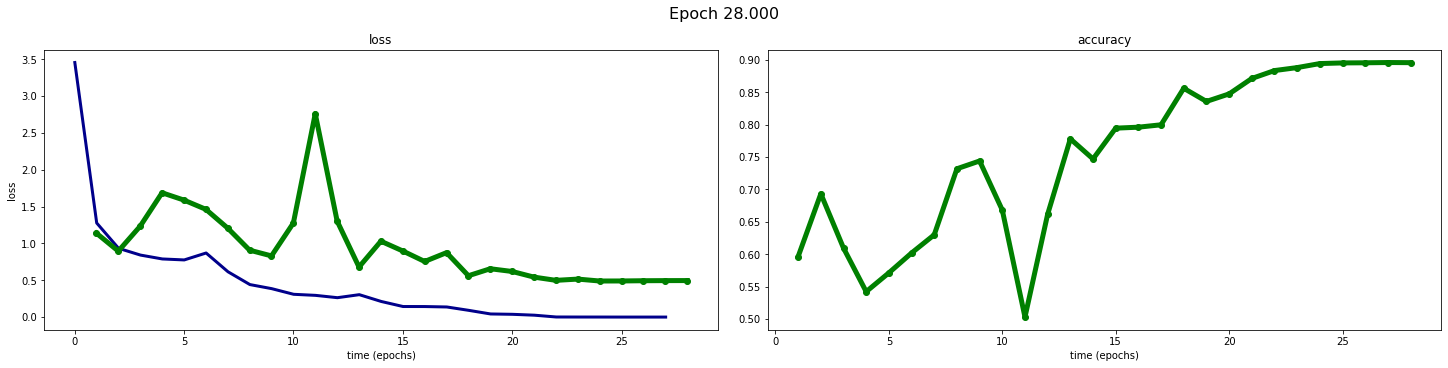

Epoch 1 LR 0.0007 Train Loss 3.4548 Val Loss 1.1386 Accuracy 0.5964
Epoch 2 LR 0.0017 Train Loss 1.2770 Val Loss 0.8953 Accuracy 0.6932
Epoch 3 LR 0.0031 Train Loss 0.9331 Val Loss 1.2336 Accuracy 0.6095
Epoch 4 LR 0.0049 Train Loss 0.8417 Val Loss 1.6871 Accuracy 0.5423
Epoch 5 LR 0.0066 Train Loss 0.7890 Val Loss 1.5879 Accuracy 0.5713
Epoch 6 LR 0.0082 Train Loss 0.7758 Val Loss 1.4626 Accuracy 0.6019
Epoch 7 LR 0.0094 Train Loss 0.8698 Val Loss 1.2071 Accuracy 0.63
Epoch 8 LR 0.0099 Train Loss 0.6150 Val Loss 0.9082 Accuracy 0.7318
Epoch 9 LR 0.0100 Train Loss 0.4414 Val Loss 0.8305 Accuracy 0.7438
Epoch 10 LR 0.0098 Train Loss 0.3858 Val Loss 1.2764 Accuracy 0.6681
Epoch 11 LR 0.0096 Train Loss 0.3094 Val Loss 2.7604 Accuracy 0.5031
Epoch 12 LR 0.0092 Train Loss 0.2950 Val Loss 1.3036 Accuracy 0.6617
Epoch 13 LR 0.0087 Train Loss 0.2634 Val Loss 0.6795 Accuracy 0.7779
Epoch 14 LR 0.0081 Train Loss 0.3044 Val Loss 1.0300 Accuracy 0.7469
Epoch 15 LR 0.0074 Train Loss 0.2123 Val Loss

In [ ]:
model = to_device(ResNet9(3, 10), device)

interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc, lr = [], [], [], []


epochs = 28
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader)) 

for t in range(epochs):
    torch.cuda.empty_cache()
    train(t, train_dataloader , model, loss_fn, optimizer, sched)
    test(t, val_dataloader , model, loss_fn)


for epoch, l, t_loss, v_loss, acc in zip(val_ts, lr, train_loss, val_loss, val_acc):
    print(f"Epoch {epoch} LR {round(l, 4):.4f} Train Loss {round(t_loss, 4):.4f} Val Loss {round(v_loss, 4):.4f} Accuracy {acc}")

### Доучиваем модель на всех данных и отправляем решение

In [36]:
data = CIFAR10(
    root=dataset_root,
    train=True,
    transform=train_transform,
)


batch_size = 512
train_dataloader = DataLoader(data, batch_size=batch_size)
device = get_default_device()
train_dataloader = DeviceDataLoader(train_dataloader, device)


In [38]:
model = to_device(ResNet9(3, 10), device)
# Training logs
interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc, lr = [], [], [], []


epochs = 28
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader)) 

for t in trange(epochs):
    torch.cuda.empty_cache()
    train(t, train_dataloader , model, loss_fn, optimizer, sched, show=False)

100%|██████████| 28/28 [11:29<00:00, 24.64s/it]


### Отправка решения

Загружаем часть датасета для теста.

In [46]:
test_data = CIFAR10(root=dataset_root, train=False, transform=test_transform)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=2, pin_memory=True)

Делаем предсказания итоговой моделью.

In [50]:
predictions = []

model.eval()
with torch.no_grad():
    for X, _ in test_dataloader:
        X = X.to(device)
        pred = model(X).argmax(1).cpu().numpy()
        predictions.extend(list(pred))

Формируем файл решения для отправки в kaggle.

In [51]:
def write_solution(filename, labels):
    with open(filename, 'w') as solution:
        print('Id,Category', file=solution)
        for i, label in enumerate(labels):
            print(f'{i},{label}', file=solution)
            
write_solution('solution.csv', predictions)